In [10]:
from skimage import data, color, feature
import skimage.data
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Visualization of HOG features')

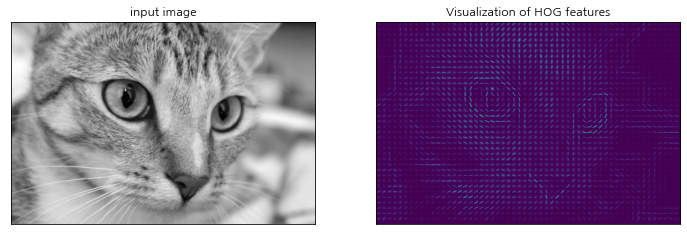

In [5]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), 
                      subplot_kw = dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('Visualization of HOG features')

In [ ]:
# 안면 인식 알고리즘 구현: linear SVM 사용

In [6]:
#1. 긍정 훈련 표본
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [7]:
print(faces.target_names)
print(faces.images.shape)

['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']
(13233, 62, 47)


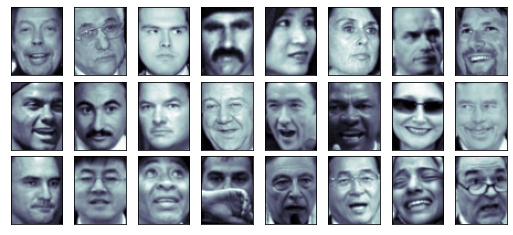

In [14]:
fig, axes = plt.subplots(3,8, figsize=(9,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))                    
for i, ax in enumerate(axes.flat):
    ax.imshow(positive_patches[i].reshape(62,47), cmap='bone')
plt.show()

<ipython-input-15-12c7e45efb66>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


10


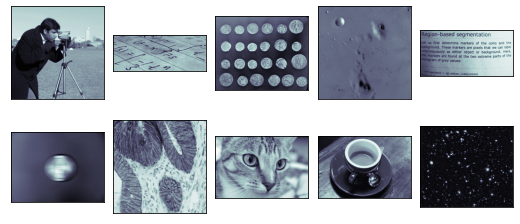

In [15]:
#2. 부정 훈련 표본
from skimage import data, transform
images_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry', 
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in images_to_use]
print(len(images))

fig, axes = plt.subplots(2,5, figsize=(9,4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))                    
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='bone')
plt.show()

In [16]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                              max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                           for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                            for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

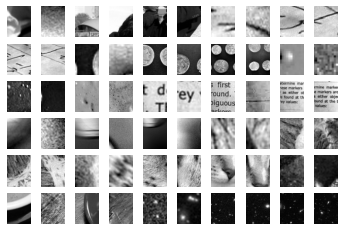

In [17]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500*i], cmap='gray')
    axi.axis('off')

In [18]:
# 집합을 결합하고 HOG 특징 추출
from itertools import chain

X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

 13223개는 1, 30000개는 0

In [19]:
X_train.shape

(43233, 1215)

In [20]:
# Naive Bayes 의 얼굴 분류 성능
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94784318, 0.97143518, 0.97224471, 0.97501735, 0.97374508])

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C':[1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9885503914410378

In [23]:
grid.best_params_

{'C': 1.0}

In [24]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

(-0.5, 139.5, 159.5, -0.5)

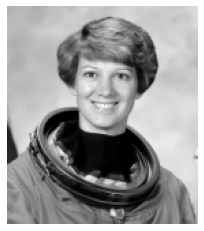

In [25]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [26]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                  istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):  #Ni
        for j in range(0, img.shape[1] - Nj, jstep): #Nj
            patch = img[i:i+Ni, j:j+Nj]
            if scale != 1:
                patch = transformation.resize(patch, patch_size)
            yield(i, j), patch

In [27]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2303, 1215)

In [28]:
labels = model.predict(patches_hog)
labels.sum()

48.0

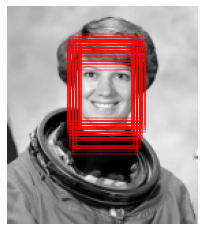

In [29]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
idxList=[]
for i, j in indices[labels==1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red',
                              alpha=0.3, lw=2, facecolor='none'))
    idxList.append([i, j]) # 사각형의 중앙 위치를 찾기 위함

In [30]:
print(idxList)

[[20, 52], [22, 46], [22, 48], [22, 50], [22, 52], [24, 44], [24, 46], [24, 48], [24, 50], [24, 52], [24, 54], [26, 44], [26, 46], [26, 48], [26, 50], [26, 52], [26, 54], [28, 44], [28, 46], [28, 48], [28, 50], [28, 52], [28, 54], [30, 44], [30, 46], [30, 48], [30, 50], [30, 52], [30, 54], [32, 44], [32, 46], [32, 48], [32, 50], [32, 52], [34, 46], [34, 48], [34, 50], [34, 52], [36, 48], [36, 50], [40, 46], [40, 48], [40, 50], [42, 46], [42, 48], [42, 50], [44, 48], [46, 48]]


In [31]:
idx = np.array(idxList)

In [32]:
idx.mean(axis=0)

array([30.41666667, 48.79166667])

In [33]:
idx.mean(axis=0).astype(int)

array([30, 48])

In [34]:
i, j = idx.mean(axis=0).astype(int)
i, j

(30, 48)

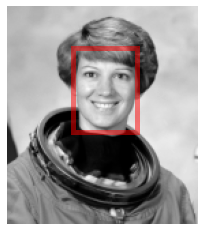

In [35]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape

ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red',
                              alpha=0.5, lw=5, facecolor='none'))
plt.show()